# Определение перспективного тарифа для телеком компании, кодовое название "Шумани на цифры"

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Выборка состоит из данных 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание данных:

1) Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

2) Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

3) Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

4) Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

5) Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Какой план работы?

- Шаг 1. Откроем файл с данными и изучим общую информацию
- Шаг 2. Приведём данные к нужному типу и исправим найденные ошибки в данных
- Шаг 3. Проанализируем данные
- Шаг 4. Проверим гипотезы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Делаю логичную догадку - если в столбце churn_date отсутствует значение, значит - пользователь продолжал пользоваться тарифом хотя бы  в январе 2019 года, на что собственно и поменяем пропущенные значения + приводим даты в нужный формат.

In [4]:
users['churn_date'].fillna('2019-01-01', inplace=True) 
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

In [5]:
users.isnull().sum()

user_id       0
age           0
churn_date    0
city          0
first_name    0
last_name     0
reg_date      0
tariff        0
dtype: int64

In [6]:
users.duplicated().sum()

0

In [7]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Приводим даты в нужый формат, округляем до целых длительность звонка.

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [9]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [10]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Приведём даты в нужный формат

In [11]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [12]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Приведём даты в нужный формат + Мб перевёдем в Гб и сделаем новый корректный столбец.

In [13]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [14]:
internet['gb_used'] = (internet['mb_used'] / 1024)

In [15]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Тут поправляем Мб на Гб снова.

In [17]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff', 'mb_per_month_included': 'gb_per_month_included'})

In [18]:
tariffs['gb_per_month_included'] = (tariffs['gb_per_month_included'] / 1024)

In [19]:
tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Добавляем в таблицу столбец с месяцев через dt.month, чтобы получить порядок не по алфавиту.

In [20]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

Соединяем в таблицу показатели по звонкам и сообщениям.

In [21]:
calls_msgs_data = calls.merge(messages, on=['user_id', 'month'], suffixes=['_calls', '_message'])
calls_msgs_data

,id_calls,call_date,duration,user_id,month,id_message,message_date
0,1000_0,2018-07-25,0,1000,7,1000_11,2018-07-06
1,1000_0,2018-07-25,0,1000,7,1000_18,2018-07-07
2,1000_0,2018-07-25,0,1000,7,1000_22,2018-07-29
3,1000_0,2018-07-25,0,1000,7,1000_26,2018-07-29
4,1000_0,2018-07-25,0,1000,7,1000_27,2018-07-30
...,...,...,...,...,...,...,...
8440792,1499_173,2018-09-27,0,1499,9,1499_143,2018-09-27
8440793,1499_173,2018-09-27,0,1499,9,1499_162,2018-09-29
8440794,1499_173,2018-09-27,0,1499,9,1499_170,2018-09-29
8440795,1499_173,2018-09-27,0,1499,9,1499_180,2018-09-28


In [22]:
calls_data_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration',
                                                   aggfunc=['sum', 'count'])
internet_data_grouped = internet.pivot_table(index=['user_id', 'month'], values='gb_used',
                                                   aggfunc=['sum'])

In [23]:
calls_data_grouped.reset_index()
calls_data_grouped.columns = ['calls_duration', 'calls_amount']

In [24]:
internet_data_grouped.columns = ['gb_used']
internet_data_grouped.reset_index()

,user_id,month,gb_used
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451
...,...,...,...
3198,1498,10,20.097031
3199,1499,9,1.802490
3200,1499,10,17.371592
3201,1499,11,17.542295


In [25]:
messages_data_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_data_grouped.reset_index()
messages_data_grouped.columns=['messages_amount']

In [26]:
calls_internet_merged = calls_data_grouped.merge(internet_data_grouped, on=['user_id', 'month'], how='left')
telecom_data = calls_internet_merged.merge(messages_data_grouped, on=['user_id', 'month'], how='left')
telecom_data_pvt = telecom_data.pivot_table(index=['user_id', 'month'])
telecom_data_pvt=telecom_data_pvt.reset_index()

In [27]:
total_data = telecom_data_pvt.merge(users, on='user_id', how='right').pivot_table(
    index=['user_id', 'first_name', 'last_name', 'age', 'city', 'tariff', 'reg_date', 'churn_date', 'month'])
total_data = total_data.reset_index()

In [28]:
total_data['gb_used'] = total_data['gb_used'].apply(np.ceil)

In [29]:
def above_the_tariff(row):
    if row['tariff'] == 'smart':
        if row['messages_amount'] > 50:
            messages_above = (row['messages_amount'] - 50)*3
        else:
            messages_above = 0
        if row['calls_amount'] > 500:
            calls_above = (row['calls_amount'] - 500)*3
        else:
            calls_above = 0
        if row['gb_used'] > 15:
            gb_above = (row['gb_used'] - 15)*200
        else:
            gb_above = 0
        total_cost = messages_above + calls_above + gb_above + 550
    if row['tariff'] == 'ultra':
        if row['messages_amount'] > 1000:
            messages_above = (row['messages_amount'] - 1000)*1
        else:
            messages_above = 0
        if row['calls_amount'] > 3900:
            calls_above = (row['calls_amount'] - 3000)*1
        else:
            calls_above = 0
        if row['gb_used'] > 30:
            gb_above = (row['gb_used'] - 30)*150
        else:
            gb_above = 0
        total_cost = messages_above + calls_above + gb_above + 1950
    return total_cost

In [30]:
total_data['total_cost'] = total_data.apply(above_the_tariff, axis=1)
total_data.pivot_table(index=['user_id', 'first_name', 'last_name', 'age', 'city', 'tariff', 'reg_date', 'churn_date', 'month'])

calls_amount  \
user_id first_name last_name age city        tariff reg_date   churn_date month                 
1000    Рафаил     Верещагин 52  Краснодар   ultra  2018-05-25 2019-01-01 5.0            22.0   
                                                                          6.0            43.0   
                                                                          7.0            47.0   
                                                                          8.0            52.0   
                                                                          9.0            58.0   
...                                                                                       ...   
1498    Всеволод   Акимчин   68  Владикавказ smart  2018-07-19 2018-10-25 10.0           41.0   
1499    Гектор     Корнилов  35  Пермь       smart  2018-09-27 2019-01-01 9.0             9.0   
                                                                          10.0           68.0   
                                                                          11.0           74.0   
                                                                          12.0           69.0   

                                                                                 calls_duration  \
user_id first_name last_name age city        tariff reg_date   churn_date month                   
1000    Рафаил     Верещагин 52  Краснодар   ultra  2018-05-25 2019-01-01 5.0             159.0   
                                                                          6.0             172.0   
                                                                          7.0             340.0   
                                                                          8.0             408.0   
                                                                          9.0             466.0   
...                                                                                         ...   
1498    Всеволод   Акимчин   68  Владикавказ smart  2018-07-19 2018-10-25 10.0            247.0   
1499    Гектор     Корнилов  35  Пермь       smart  2018-09-27 2019-01-01 9.0              70.0   
                                                                          10.0            449.0   
                                                                          11.0            612.0   
                                                                          12.0            492.0   

                                                                                 gb_used  \
user_id first_name last_name age city        tariff reg_date   churn_date month            
1000    Рафаил     Верещагин 52  Краснодар   ultra  2018-05-25 2019-01-01 5.0        3.0   
                                                                          6.0       23.0   
                                                                          7.0       14.0   
                                                                          8.0       14.0   
                                                                          9.0       15.0   
...                                                                                  ...   
1498    Всеволод   Акимчин   68  Владикавказ smart  2018-07-19 2018-10-25 10.0      21.0   
1499    Гектор     Корнилов  35  Пермь       smart  2018-09-27 2019-01-01 9.0        2.0   
                                                                          10.0      18.0   
                                                                          11.0      18.0   
                                                                          12.0      13.0   

                                                                                 messages_amount  \
user_id first_name last_name age city        tariff reg_date   churn_date month                    
1000    Рафаил     Верещагин 52  Краснодар   ultra  2018-05-25 2019-01-01 5.0               22.0   
                                  

Посчитала для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя;

Поищу-таки пропуски в новой таблице, а вдруг что, как говорится

In [31]:
total_data.isna().sum()

user_id              0
first_name           0
last_name            0
age                  0
city                 0
tariff               0
reg_date             0
churn_date           0
month                0
calls_amount         0
calls_duration       0
gb_used             11
messages_amount    496
total_cost           0
dtype: int64

Вдруг что - нашлось, 11 и 496 пропусоков с столбце с использованными Гб и смс-ками, значит этими опциями траифа не пользовались, заменяют пропуски на нули.

In [32]:
total_data['gb_used']= total_data['gb_used'].fillna(0)
total_data['messages_amount']= total_data['messages_amount'].fillna(0)

Да, немного о том, что я сделала с пропусками в столбце со звонками - там было много нулевых значений, в документации было заявлено, что это могут быть пропущенные звонки. Так вот, с нулевыми показателями я не стала ничего делать, особенно - округлять это до единицы, это тут же бы сказалось на качестве исследования, так как я собственноручно добавила бы некорретные данные о поведении пользователей.

Проверка:

In [33]:
total_data.isna().sum()

user_id            0
first_name         0
last_name          0
age                0
city               0
tariff             0
reg_date           0
churn_date         0
month              0
calls_amount       0
calls_duration     0
gb_used            0
messages_amount    0
total_cost         0
dtype: int64

Отлично, поехали дальше!

In [34]:
smart_data = total_data.query('tariff == "smart"')
ultra_data = total_data.query('tariff == "ultra"')

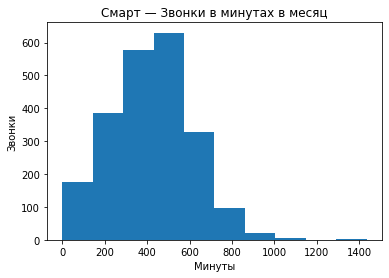

In [35]:
smart_data['calls_duration'].plot(kind='hist', bins=10)
plt.title('Смарт — Звонки в минутах в месяц')
plt.xlabel('Минуты')
plt.ylabel('Звонки');

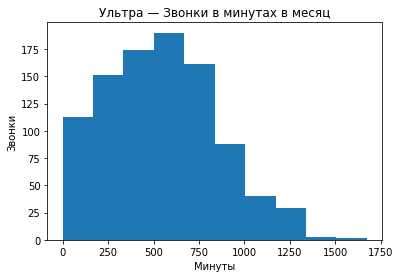

In [36]:
ultra_data['calls_duration'].plot(kind='hist', bins=10)
plt.title('Ультра — Звонки в минутах в месяц')
plt.xlabel('Минуты')
plt.ylabel('Звонки');

In [37]:
total_data.groupby('tariff')\
  .agg({'calls_duration':['median','mean','var','std']})\
  .style.format("{:.2f}")

Пользователи Smart выходят за границы тарифного плана, в то время, как Ультравцы ожидаемо нет, тяжело все-таки проговорить все 3000 пакетных минут.

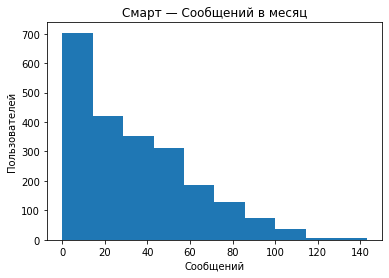

In [38]:
smart_data['messages_amount'].plot(kind='hist', bins=10)
plt.title('Смарт — Сообщений в месяц')
plt.xlabel('Сообщений')
plt.ylabel('Пользователей');

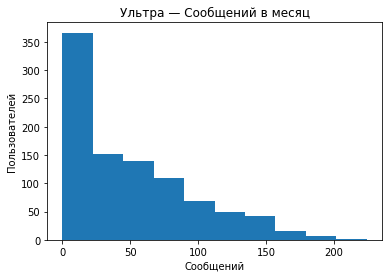

In [39]:
ultra_data['messages_amount'].plot(kind='hist', bins=10)
plt.title('Ультра — Сообщений в месяц')
plt.xlabel('Сообщений')
plt.ylabel('Пользователей');

In [40]:
total_data.groupby('tariff')\
  .agg({'messages_amount':['median','mean','var','std']})\
  .style.format("{:.2f}")

То же самое касается и сообщений: смартовцы выходят, а ультравцы сидят с минимум 1500 вакантных сообщений в пакете в месяце.

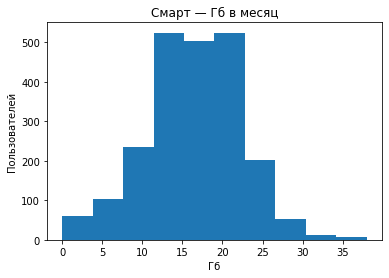

In [41]:
smart_data['gb_used'].plot(kind='hist', bins=10)
plt.title('Смарт — Гб в месяц')
plt.xlabel('Гб')
plt.ylabel('Пользователей');

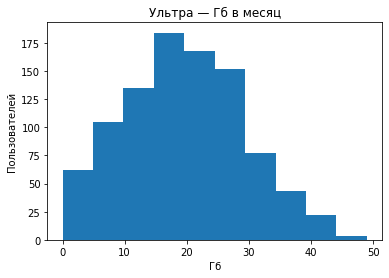

In [42]:
ultra_data['gb_used'].plot(kind='hist', bins=10)
plt.title('Ультра — Гб в месяц')
plt.xlabel('Гб')
plt.ylabel('Пользователей');

In [43]:
total_data.groupby('tariff')\
  .agg({'gb_used':['median','mean','var','std']})\
  .style.format("{:.2f}")

Смартовцы снова заплывают за буйки по интернет трафиук, причем судя по распределению - довольно большое количество пользователей. Ультравцы тоже заплывают, но их спасает граница в два раза большая, чем у Smart - 30 Гб против 15 Гб.

In [44]:
display(total_data.groupby('tariff')['total_cost'].mean())

tariff
smart    1165.737292
ultra    2070.977918
Name: total_cost, dtype: float64

После такого сопоставления возникает резонный вопрос - может быть стоит некоторым пользователям перейти на Ultra? И вам приятно, и оператору богато.

Посчитаем среднее, дисперсию и ст. отклонение для тарифа Smart.

In [45]:
smart_data = total_data.query('tariff == "smart"')
smart_data[['total_cost']].describe()

,total_cost
count,2223.000000
mean,1165.737292
std,741.252882
min,550.000000
25%,550.000000
50%,950.000000
75%,1550.000000
max,5249.000000


Посчитаем дисперсию и мат.ожидание для тарифов Smart:

In [46]:
variance_smart = np.var(smart_data[['total_cost']])
variance_smart
 
expectation_smart = variance_smart**0.5
expectation_smart

total_cost    741.08614
dtype: float64

Посчитаем среднее, дисперсию и ст. отклонение для тарифа Ultra.

In [47]:
ultra_data = total_data.query('tariff == "ultra"')
ultra_data[['total_cost']].describe()

,total_cost
count,951.000000
mean,2070.977918
std,379.423372
min,1950.000000
25%,1950.000000
50%,1950.000000
75%,1950.000000
max,4800.000000


Посчитаем дисперсию и мат.ожидание для тарифов Ultra:

In [48]:
variance_ultra = np.var(ultra_data[['total_cost']])
variance_ultra
 
expectation_ultra = variance_ultra**0.5
expectation_ultra

total_cost    379.223833
dtype: float64

Построим гистограммы и посмотрим, сколько пользователи тратят на выбранный ими тарифный план в месяц.

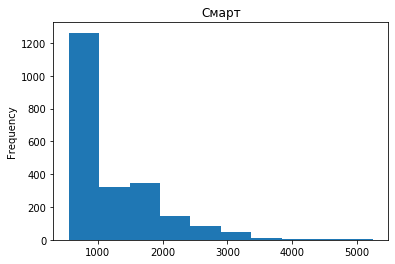

In [49]:
smart_data['total_cost'].plot(kind='hist', bins=10)
plt.title('Смарт');

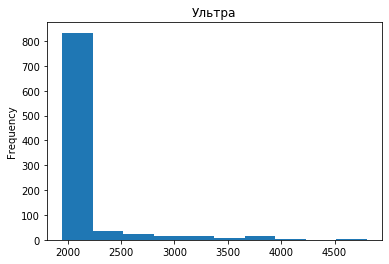

In [50]:
ultra_data['total_cost'].plot(kind='hist', bins=10)
plt.title('Ультра');

Теперь посчитаем среднее, дисперсию и ст.отклонение для трафика, звонков и сообщений для представленных тарифов.

In [51]:
cols_to_analyse = ['calls_duration', 'gb_used', 'messages_amount', 'total_cost']
def var_mean_sigma(row):
    for col in cols_to_analyse:
        print(col, ':')
        variance = np.var(row[[col]])
        expectation = variance*0.5
        parameters = row[[col]].describe().T
        sigma = parameters['std'][0]
        mean = parameters['mean'][0]
        print('Дисперсия', variance)
        print('Стандратное отклонение', sigma)
        print('Среднее', mean)
        print()

In [52]:
var_mean_sigma(smart_data)

calls_duration :
Дисперсия calls_duration    35828.06531
dtype: float64
Стандратное отклонение 189.3256177894154
Среднее 419.0629779577148

gb_used :
Дисперсия gb_used    33.07751
dtype: float64
Стандратное отклонение 5.7525990894692836
Среднее 16.32973459289249

messages_amount :
Дисперсия messages_amount    798.23655
dtype: float64
Стандратное отклонение 28.259437219588445
Среднее 33.396311291048136

total_cost :
Дисперсия total_cost    549208.666927
dtype: float64
Стандратное отклонение 741.2528823174168
Среднее 1165.7372919478182



In [53]:
 var_mean_sigma(ultra_data)

calls_duration :
Дисперсия calls_duration    94104.361174
dtype: float64
Стандратное отклонение 306.92575388218586
Среднее 545.4511041009464

gb_used :
Дисперсия gb_used    97.717782
dtype: float64
Стандратное отклонение 9.890431896048614
Среднее 19.487907465825447

messages_amount :
Дисперсия messages_amount    2196.421581
dtype: float64
Стандратное отклонение 46.89065582191353
Среднее 49.03364879074658

total_cost :
Дисперсия total_cost    143810.715601
dtype: float64
Стандратное отклонение 379.42337210739254
Среднее 2070.9779179810726



Видим информацию, которая уже просматривалась в гистограммах, приведённых выше. Пользователи тарифа Smart тратят в среднем лишь на 741 рублей меньше в месяц, чем пользователи тарифа Ultra, учитывая стандартное отклоение смартовцев. Ультравцы, конечно, тоже переплачивают, но сильне меньше, в два раза - 380 рублей. Из чего складывается переплата у смартовцев? Это звонки и интернет трафик  с отклонениями в 190 минут и 5 Гб. Смс-ки, что у Смарта, что у Ультры вылезают за пределы несильно: 28 и 46 отклоения соотвественно. Вполне логично, данные зв 2018 год, мессенджеры во всём ходу, а Дуров так и не вернул стену. 

Поехали работать с гипотезами. Сначала установим формулировку нулевой гипотезы, а оттуда и выясним, как звучит альтернативная гипотеза. 

Итак, из теории я уяснила, что в гипотезе две сравниваемые величины либо равны, либо не равны друг другу. Поэтому сформулирую нулевую гипотезу так: "Средняя выручка пользователей тарифов Ultra и Smart равны друг другу". Альтернативная гипотеза будет соответственно перевёртышем нулевой: т.е. средняя выручка тарифов не равна. 

In [54]:
alpha = 0.05
 
results = st.ttest_ind(smart_data['total_cost'], ultra_data['total_cost'])
print('p-значение:', results.pvalue)
if results.pvalue > alpha:
    print('Средняя выручка тарифов равны')
else:
    print('Средняя выручка отличается')

p-значение: 4.657090039411243e-235
Средняя выручка отличается


Разберёмся со второй гипотезой и сформулируем её сразу в виде нулевой: "Средняя выручка пользователей из Москвы равна выручки пользователей из других регионов". По такому же принципу перевёртыша звучит альтернативная гипотеза: что эти выручки не равны. 

In [55]:
moscow = total_data.query('city == "Москва"')
not_moscow = total_data.query('city != "Москва"')
results_city = st.ttest_ind(moscow['total_cost'], not_moscow['total_cost'])
print('p-значение:', results_city.pvalue)
if results_city.pvalue > alpha:
    print('Регионы и Москва идут вровень')
else:
    print('Наблюдаем разницу в счетах абонентов из Москвы и регионов')

p-значение: 0.2251949609364987
Регионы и Москва идут вровень


- Выводы и заключение:

Разные тарифы - разные карты поведения пользователей. Можно предположить, что еще в 2018 году людям не нужны смс-сообщения в таком количестве, в котором их предлагают изначальные тарифные планы. Думаю, что в 2020 году эти слова становятся более чем, легитимными. Доходность москвичей и людей из регионов по тарифам - не отличаются, всё-таки и в регионах есть прослойка людей, которые готовы тратить на мобильные планы повышенных объёмов, если им это выгодно. 

Постоянные выпады за границы абонентского плана, а значит повышение расходов на мобильную связь - может привести к разочарованию пользователей тарифа Smart. Это нужно учитывать при построении более сбалансированного ранжирования планов - все-таки должна быть ступень где-то посередине между 550 рублей в месяц и 1950 рублей во избежании совершенно справдливо недовольных пользователей, которые будут махать экспликацией по расходам в офисах связи "Мегалайна".

Из прикольных идей-манипуляций, что появились, пока анализировала показатели по тарифам: возможно "Мегалайну" стоит сделать стратификацию тарифа Smart, что я имею под этим в виду, сделать два варианта тарифа Smart - условный SmartMini и Smart. В Мини идёт нынешняя версия Смарта, только с чуть меньшим встроенным пакетом и дешевле (450 рублей), в Smart ver2 (да еще с пометкой "Оптимальный") идет тариф с увеличенным пакетом тарифного плата (несильно) и абонентской платой (допустим 650 рублей). В чем логика данной уловки? Пользователи глянут на тарифные планы, абон плату, и поразмыслив ("Нет, ну куда столько минут и Гб, конечно, я их быстро потрачу и потом придется подключать дополнительные пакеты и переплачивать"), выберет Smart ver2. То есть, оператор изначально ставит условия (селки) так, чтобы подвести пользователя к нужному (для оператора) варианту тарифного плана. Грешновато, но кто без греха в области денег? Да и греха тут немного, ведь Smart ver2 может быть на сотку рублей дороже, но те, кто поместится в ограничения выиграет в конце концов. 

Вот что правда грешновато, так это давать на аналитику внешним контрагентам незашифрованные данные пользователей (и имя, и фамилия, и возраст, и город - ноу буэно), где-то отдел безопасности "Мегалайна" нервно ёрзает.

"Спасибо, что дочитали до конца!"